# Setup
Produce dataframes that will be used directly as model inputs

In [1]:
import os
import datetime
import sys

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
import time
import sqlite3


In [3]:
tf.__version__

'2.1.0'

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
pd.options.display.max_rows=200
pd.options.display.max_columns=50

# Read Data

In [6]:
def get_tables(db):
    table_names=[]
    conn = sqlite3.connect(db)
    try:
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        tables = cursor.fetchall()
        table_names = [ttt[0] for ttt in tables]
        conn.close()
    except:
        conn.close()
    return(table_names)

In [7]:
# Read {bike, dock, weather} data (1 minute)

tic=time.time()
data={}
db='cabi_data_for_TF.db'
table_names = ['bike','dock','weather']
conn=sqlite3.connect(db)
for table_name in table_names:
    query = 'select * from '+table_name
    data[table_name]=pd.read_sql_query(query,conn)
conn.close()
print(time.time()-tic)

66.22629809379578


In [8]:
print(data['bike'].shape)
print(data['dock'].shape)
print(data['weather'].shape)

(90133, 619)
(90133, 619)
(90133, 7)


In [9]:
dt0 = pd.to_datetime(data['weather'].datetime,format='%Y-%m-%d %H:%M:%S')
dt1 = pd.to_datetime(data['bike'].datetime,format='%Y-%m-%d %H:%M:%S')
dt2 = pd.to_datetime(data['dock'].datetime,format='%Y-%m-%d %H:%M:%S')
assert all(dt0==dt1)
assert all(dt0==dt2)

In [10]:
bike=data['bike'].drop(columns='datetime')
dock=data['dock'].drop(columns='datetime')
weather=data['weather'].drop(columns='datetime')

# PreProcessing

In [11]:
# weather: actually let's move this after the TVT splitting, so that weather preproc can occur all in one place

In [12]:
weather.head()

,temp,dew,wspd_x,wspd_y,precip,snowdepth
0,71.7,42.9,-6.156002,6.836932,0.0,0.0
1,73.6,42.5,-5.466403,7.523858,0.0,0.0
2,74.9,39.4,1.133385,-9.230679,0.0,0.0
3,76.0,39.0,3.868238,-9.112998,0.0,0.0
4,77.4,35.7,0.620833,-8.878320,0.0,0.0


In [13]:
weather.describe()

,temp,dew,wspd_x,wspd_y,precip,snowdepth
count,90133.000000,90133.000000,90133.000000,90133.000000,90133.000000,90133.000000
mean,59.291620,45.732405,1.310378,-0.060771,0.004610,0.044091
std,17.659689,19.053454,5.138549,7.082247,0.033818,0.545094
min,6.000000,-14.900000,-25.300000,-38.903275,0.000000,0.000000
25%,44.800000,30.400000,-1.693453,-5.200352,0.000000,0.000000
50%,60.100000,47.900000,0.555674,0.000000,0.000000,0.000000
75%,74.100000,62.600000,4.088480,5.168309,0.000000,0.000000
max,105.300000,80.300000,34.768627,27.556505,2.570000,18.220000


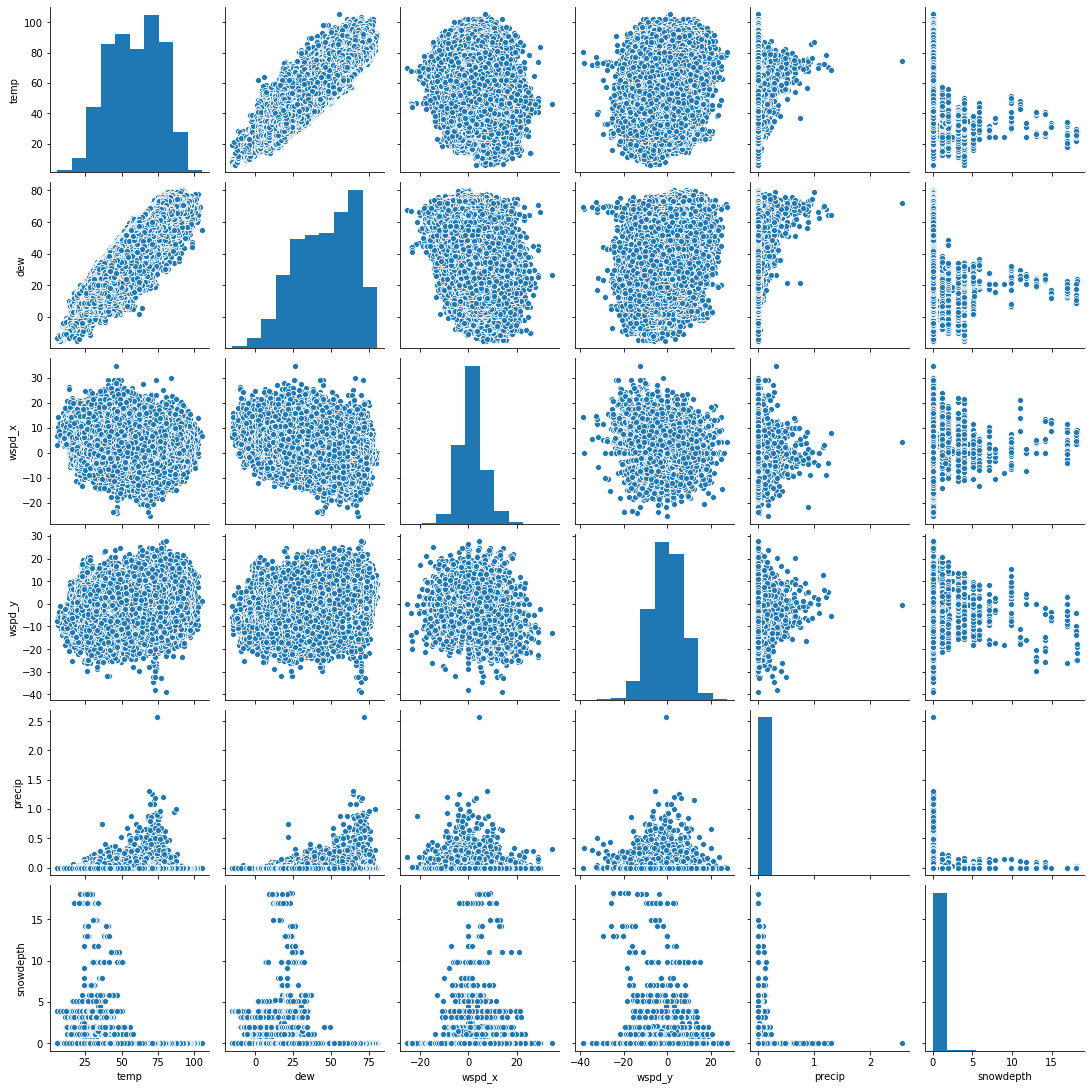

In [14]:
sns.pairplot(weather)

Four fields (temp / dew / wspd_x / wspd_y) are close to normally distributed.
The other two (precip / snowdepth) are not. These are not only positive-definite, but they are also both very right-skewed and both dominated by a large majority of zeros.

The correlated variables (e.g. temp and dew) are worth noting but won't be a problem for this task.

In [15]:
# We'll address this with the following Transformation:
# Logarithms of precip and snowdepth to make the data somewhat less right-skewed

In [16]:
weather['precip'] = np.log10(1+weather.precip)
weather['snowdepth'] = np.log10(1+weather.snowdepth)

In [17]:
lbike = np.log10(1+bike)
ldock = np.log10(1+dock)

We will also want to normalize our features as part of preprocessing. However, to avoid leakage, we'll wait until defining our data splitting.

##  Date & Time Conversions

In [18]:
dt = pd.DataFrame(dt0,columns=['datetime'])

In [19]:
dt['hour']=dt.datetime.dt.hour
dt['doy']=dt.datetime.dt.dayofyear
dt['dow']=dt.datetime.dt.dayofweek

In [20]:
dt['day_sin']=np.sin(2*np.pi*dt.hour/24)
dt['day_cos']=np.cos(2*np.pi*dt.hour/24)
dt['week_sin']=np.sin(2*np.pi*(dt.dow+(dt.hour/24))/7)
dt['week_cos']=np.cos(2*np.pi*(dt.dow+(dt.hour/24))/7)

day = 24*60*60
year = (365.2425)*day
posix_time = dt.datetime.apply(lambda x: x.timestamp())
dt['year_sin'] = np.sin(posix_time * (2 * np.pi / year))
dt['year_cos'] = np.cos(posix_time * (2 * np.pi / year))
#dt['year_sin']=np.cos
#dt['year_cos']

In [21]:
dt

,datetime,hour,doy,dow,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos
0,2010-09-20 11:00:00,11,263,0,2.588190e-01,-0.965926,0.399892,0.916562,-0.981583,-0.191034
1,2010-09-20 12:00:00,12,263,0,1.224647e-16,-1.000000,0.433884,0.900969,-0.981720,-0.190331
2,2010-09-20 13:00:00,13,263,0,-2.588190e-01,-0.965926,0.467269,0.884115,-0.981856,-0.189627
3,2010-09-20 14:00:00,14,263,0,-5.000000e-01,-0.866025,0.500000,0.866025,-0.981992,-0.188923
4,2010-09-20 15:00:00,15,263,0,-7.071068e-01,-0.707107,0.532032,0.846724,-0.982127,-0.188219
...,...,...,...,...,...,...,...,...,...,...
90128,2020-12-31 19:00:00,19,366,3,-9.659258e-01,0.258819,-0.258819,-0.965926,0.007297,0.999973
90129,2020-12-31 20:00:00,20,366,3,-8.660254e-01,0.500000,-0.294755,-0.955573,0.008014,0.999968
90130,2020-12-31 21:00:00,21,366,3,-7.071068e-01,0.707107,-0.330279,-0.943883,0.008730,0.999962
90131,2020-12-31 22:00:00,22,366,3,-5.000000e-01,0.866025,-0.365341,-0.930874,0.009447,0.999955


Text(0.5, 1.0, 'Time of day signal')

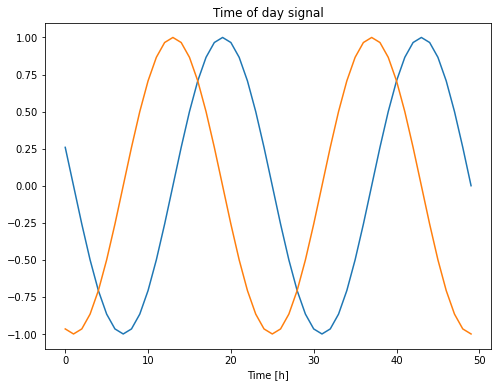

In [22]:
plt.plot(np.array(dt['day_sin'])[:50])
plt.plot(np.array(dt['day_cos'])[:50])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Time of year signal')

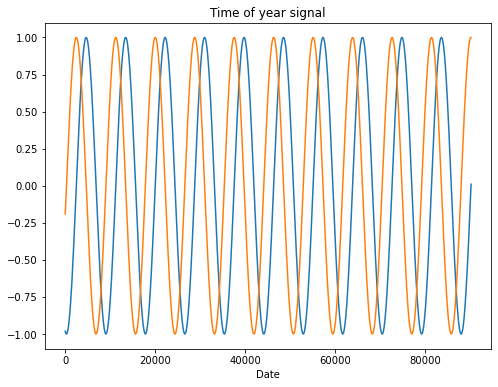

In [23]:
plt.plot(np.array(dt['year_sin']))
plt.plot(np.array(dt['year_cos']))
plt.xlabel('Date')
plt.title('Time of year signal')

Which frequencies are most prominent in the bikeshare ridership data?

Let's aggregate over all stations to investigate total system ridership

In [24]:
tic=time.time()
agg_BD = pd.concat([dt.datetime,\
                    pd.Series(bike.sum(axis=1),name='bike'),
                   pd.Series(dock.sum(axis=1),name='dock')],axis=1)
print(time.time()-tic)

0.10299897193908691


datetime
2010    AxesSubplot(0.125,0.125;0.775x0.755)
2011    AxesSubplot(0.125,0.125;0.775x0.755)
2012    AxesSubplot(0.125,0.125;0.775x0.755)
2013    AxesSubplot(0.125,0.125;0.775x0.755)
2014    AxesSubplot(0.125,0.125;0.775x0.755)
2015    AxesSubplot(0.125,0.125;0.775x0.755)
2016    AxesSubplot(0.125,0.125;0.775x0.755)
2017    AxesSubplot(0.125,0.125;0.775x0.755)
2018    AxesSubplot(0.125,0.125;0.775x0.755)
2019    AxesSubplot(0.125,0.125;0.775x0.755)
2020    AxesSubplot(0.125,0.125;0.775x0.755)
Name: bike, dtype: object

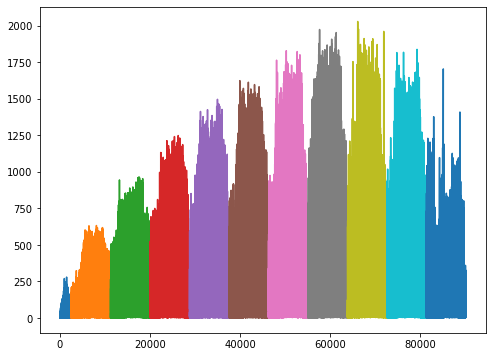

In [25]:
agg_BD.iloc[:].groupby(agg_BD.iloc[:].datetime.dt.year)['bike'].plot()

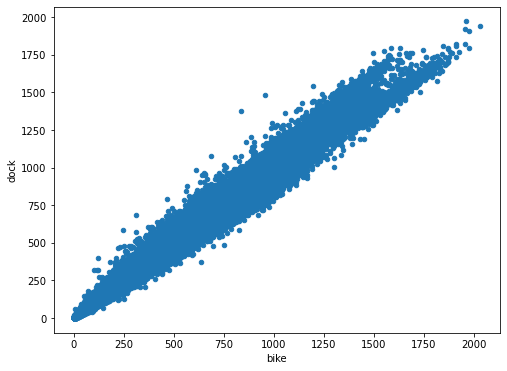

In [26]:
agg_BD.plot.scatter('bike','dock')

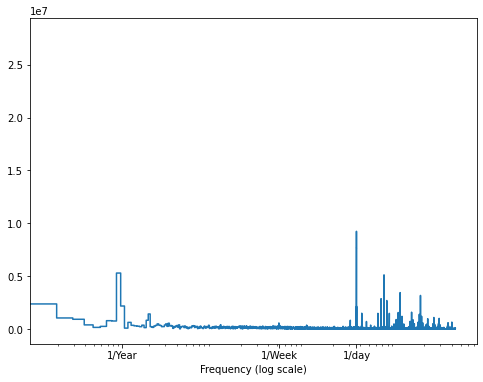

In [27]:
fft = tf.signal.rfft(agg_BD.bike)
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(agg_BD.bike)
hours_per_year = 24*365.2425
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2425/7, 365.2425], labels=['1/Year','1/Week', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [28]:
# Yearly and Daily components are obvious
# Daily component has harmonics

# There is a very faint blip visible at weekly frequency, but not as much as I would have expected.
    # Perhaps differences in weekend ridership are 
    
    # Move this entire section back to 01 EDA ~!!!!!!!!!!!!!!!!!!11 ???
        # Then can use Member/Casual to investigate this more thoroughly


In [29]:
# Interesting, 
# Might the weekly cycle be more obvious if we downsample to a daily series from the 8am hour only?

In [30]:
agg_BD

,datetime,bike,dock
0,2010-09-20 11:00:00,2,2
1,2010-09-20 12:00:00,17,14
2,2010-09-20 13:00:00,11,13
3,2010-09-20 14:00:00,6,4
4,2010-09-20 15:00:00,12,11
...,...,...,...
90128,2020-12-31 19:00:00,95,98
90129,2020-12-31 20:00:00,83,98
90130,2020-12-31 21:00:00,49,42
90131,2020-12-31 22:00:00,42,46


In [31]:
agg_BD_h08 = agg_BD[dt.hour==8]
len(agg_BD_h08)

3755

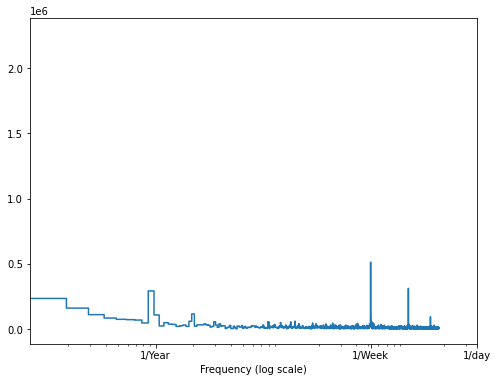

In [32]:
fft_08 = tf.signal.rfft(agg_BD_h08.bike)
f_per_dataset = np.arange(0, len(fft_08))

n_samples_days = len(agg_BD_h08.bike)
days_per_year = 365.2425
years_per_dataset = n_samples_days/(days_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.step(f_per_year, np.abs(fft_08))
plt.xscale('log')
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2425/7, 365.2425], labels=['1/Year','1/Week', '1/day'])
_ = plt.xlabel('Frequency (log scale)')

In [33]:
# Yes! Now the weekly pattern shows the strongest signal.

# Splitting the data

In [34]:
# We'll need to split data into {train, validation, test}

# Considerations:
    # 1) It's a time series, so split must be sequential, not random
    # 2) We expect three types of seasonality in this data:
        # a) daily
        # b) weekly
        # c) yearly
        
        # Ideally, the sub-groups should contain integer number of cycles
            # to mitigate seasonal bias
        # In practice, have to choose between integer weeks vs integer years
            # choose years
            # With a full year Validation period, the weekday bias is a small fraction anyway
    
    # 3) 2020 Pandemic: We expect most recent year to "break" the model
        # We'll consider two versions of the test set:
            # 2019
            # 2020
    
    # 4) Also we don't yet know what lag values will be most necessary for training
        # Consider two start dates for training set:
            # 2012 JAN 01
            # 2013 JAN 01
    
# This leaves four combinations
    # they will be denoted by the final digit of the years defining the training set
    
    # 27: Train on 6 years (2012-2017), Val 2018, Test 2019
    # 28: Train on 7 years (2012-2018), Val 2019, Test 2020
    # 37: Train on 5 years (2013-2017), Val 2018, Test 2019
    # 38: Train on 6 years (2013-2018), Val 2019, Test 2020

# Q) Train on 6 years (2012-2017), Val 2018, Test 2019
# R) Train on 7 years (2012-2018), Val 2019, Test 2020

# Factors:
    # 1) Don't shuffle! Separate by timestamp (Train < Val < Test): 
    # 2) use full years to avoid seasonal bias
    # 3) start point in 2012:
        # allow use of lags from a full year prior
        # earliest data may be less useful anyway due to drift

In [35]:
# Boolean vectors:
splitter_masks = {}
for key in (27,28,37,38):
    first_train_year = 2010+(key//10)
    final_train_year = 2010+(key%10)
    ps_year = dt.datetime.dt.year
    mask_train = ((ps_year>=first_train_year) & (ps_year<=final_train_year))
    mask_val = (ps_year==(1+final_train_year))
    mask_test = (ps_year==(2+final_train_year))
    splitter_masks[key] = {'train':mask_train,'val':mask_val,'test':mask_test}
# two-digit keys that identify the first and last year of the training set

### Scaling for weather features:

In [36]:
cols_w = weather.columns

In [37]:
weather[cols_w].describe()

,temp,dew,wspd_x,wspd_y,precip,snowdepth
count,90133.000000,90133.000000,90133.000000,90133.000000,90133.000000,90133.000000
mean,59.291620,45.732405,1.310378,-0.060771,0.001814,0.007251
std,17.659689,19.053454,5.138549,7.082247,0.011835,0.069575
min,6.000000,-14.900000,-25.300000,-38.903275,0.000000,0.000000
25%,44.800000,30.400000,-1.693453,-5.200352,0.000000,0.000000
50%,60.100000,47.900000,0.555674,0.000000,0.000000,0.000000
75%,74.100000,62.600000,4.088480,5.168309,0.000000,0.000000
max,105.300000,80.300000,34.768627,27.556505,0.552668,1.283753


In [38]:
# Normalize wrt training set only (to avoid any leakage)

# TF notebook normalizes sinusoidal engineered datetime features along with the weather features
    # not necessary to normalize the sinusoidal features: they're already scaled well enough
(mu_w,sigma_w)=({},{})
for key in splitter_masks:
    mu_w[key]=weather.loc[splitter_masks[key]['train'],cols_w].mean().rename('mu_'+str(key))
    sigma_w[key]=weather.loc[splitter_masks[key]['train'],cols_w].std().rename('sigma_'+str(key))
pd.concat([ms[key] for key in splitter_masks for ms in (mu_w,sigma_w)],axis=1)

,mu_27,sigma_27,mu_28,sigma_28,mu_37,sigma_37,mu_38,sigma_38
temp,59.427213,17.731758,59.358951,17.815062,59.105406,17.892693,59.079351,17.961623
dew,45.461639,19.199755,45.631357,19.366675,45.296977,19.573209,45.522476,19.704407
wspd_x,1.334926,5.269942,1.271716,5.287308,1.330833,5.262557,1.257745,5.283952
wspd_y,-0.159758,7.387487,-0.180118,7.313613,-0.100299,7.371166,-0.133965,7.287628
precip,0.001615,0.010856,0.001803,0.012027,0.001657,0.011011,0.001870,0.012326
snowdepth,0.008926,0.078103,0.008003,0.073496,0.010545,0.084611,0.009198,0.078554


In [39]:
weather_stdz = {k:weather.copy() for k in splitter_masks}
for k in splitter_masks:
    weather_stdz[k][cols_w] = (weather[cols_w]-mu_w[k])/sigma_w[k]
weather_stdz[27].describe()

,temp,dew,wspd_x,wspd_y,precip,snowdepth
count,90133.000000,90133.000000,90133.000000,90133.000000,90133.000000,90133.000000
mean,-0.007647,0.014103,-0.004658,0.013399,0.018311,-0.021440
std,0.995936,0.992380,0.975067,0.958681,1.090185,0.890805
min,-3.013080,-3.143875,-5.054121,-5.244478,-0.148775,-0.114282
25%,-0.824916,-0.784470,-0.574651,-0.682315,-0.148775,-0.114282
50%,0.037943,0.127000,-0.147867,0.021626,-0.148775,-0.114282
75%,0.827486,0.892634,0.522502,0.721229,-0.148775,-0.114282
max,2.587041,1.814521,6.344225,3.751785,50.760196,16.322386


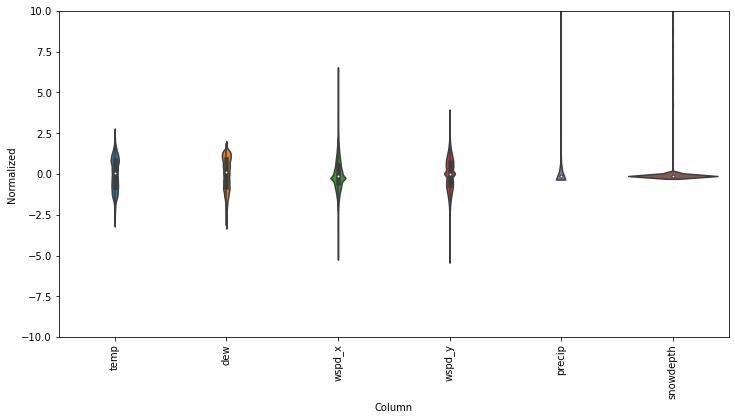

In [40]:
# Visualize violin plots for split 27:
w_melted_27 = weather_stdz[27][cols_w].melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=w_melted_27)
_ = ax.set_xticklabels(cols_w, rotation=90)
_ = ax.set_ylim((-10, 10))

Purpose of normalization is scaling the data for easier training. Doesn't need to be perfect. So we'll just base all of our normalization computations off of dataset 27.

### Generate full dataframe

In [41]:
u_sta = list(bike.columns[1:])
assert all(dock.columns[1:]==u_sta)
u_sta[:5] # columns of ridership data are strings of the terminal names

['31001', '31002', '31003', '31004', '31005']

In [42]:
d_colsB = {c:('B_'+str(c)) for c in bike.columns}
d_colsD = {c:('D_'+str(c)) for c in dock.columns}
df_bike = bike.rename(columns=d_colsB)
df_dock = dock.rename(columns=d_colsD)
df_bike.head()

,B_31000,B_31001,B_31002,B_31003,B_31004,B_31005,B_31006,B_31007,B_31009,B_31010,B_31011,B_31012,B_31013,B_31014,B_31015,B_31016,B_31017,B_31018,B_31019,B_31020,B_31021,B_31022,B_31023,B_31024,B_31025,...,B_32409,B_32410,B_32411,B_32412,B_32413,B_32414,B_32415,B_32416,B_32417,B_32418,B_32419,B_32420,B_32421,B_32422,B_32423,B_32600,B_32601,B_32602,B_32603,B_32604,B_32605,B_32606,B_32607,B_32608,B_32609
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
cols_dt = ['day_sin','day_cos','week_sin','week_cos','year_sin','year_cos']
cols_B = list(d_colsB.values())
cols_D = list(d_colsD.values())
cols_w = list(cols_w)

In [44]:
agg_BD

,datetime,bike,dock
0,2010-09-20 11:00:00,2,2
1,2010-09-20 12:00:00,17,14
2,2010-09-20 13:00:00,11,13
3,2010-09-20 14:00:00,6,4
4,2010-09-20 15:00:00,12,11
...,...,...,...
90128,2020-12-31 19:00:00,95,98
90129,2020-12-31 20:00:00,83,98
90130,2020-12-31 21:00:00,49,42
90131,2020-12-31 22:00:00,42,46


In [45]:
# C === Calendar/Clock sinusoids
# W === Weather
# A === Ridership counts, aggregated over all stations
# S === Ridership counts, by station

# using normalizations defined by split 27 only
tic=time.time()
k=27

df_CW = pd.concat([dt[cols_dt],weather_stdz[k][cols_w]],axis=1)

rides_agg = agg_BD.drop('datetime',axis=1)
cu_renamer = lambda x: ('cu'+x)
curides_agg = rides_agg.cumsum().rename(columns=cu_renamer)
cudf_bike = df_bike.cumsum().rename(columns=cu_renamer)
cudf_dock = df_dock.cumsum().rename(columns=cu_renamer)

df_CWA = pd.concat([df_CW,rides_agg,curides_agg],axis=1)
df_CWS = pd.concat([df_CW,df_bike,df_dock,cudf_bike,cudf_dock],axis=1)

print(time.time()-tic)

2.293003559112549


In [46]:
print(df_CWA.shape)
print(df_CWS.shape)

(90133, 16)
(90133, 2484)


In [47]:
sys.getsizeof(df_CWS)
# another set of tables for DB

1791123128

In [48]:
df_CWA.drop(['cubike','cudock'],axis=1)

,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos,temp,dew,wspd_x,wspd_y,precip,snowdepth,bike,dock
0,2.588190e-01,-0.965926,0.399892,0.916562,-0.981583,-0.191034,0.692136,-0.133420,-1.421444,0.947100,-0.148775,-0.114282,2,2
1,1.224647e-16,-1.000000,0.433884,0.900969,-0.981720,-0.190331,0.799288,-0.154254,-1.290589,1.040085,-0.148775,-0.114282,17,14
2,-2.588190e-01,-0.965926,0.467269,0.884115,-0.981856,-0.189627,0.872603,-0.315714,-0.038244,-1.227876,-0.148775,-0.114282,11,13
3,-5.000000e-01,-0.866025,0.500000,0.866025,-0.981992,-0.188923,0.934639,-0.336548,0.480710,-1.211947,-0.148775,-0.114282,6,4
4,-7.071068e-01,-0.707107,0.532032,0.846724,-0.982127,-0.188219,1.013593,-0.508425,-0.135503,-1.180180,-0.148775,-0.114282,12,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90128,-9.659258e-01,0.258819,-0.258819,-0.965926,0.007297,0.999973,-0.909510,-0.701136,-0.777364,-0.744860,-0.148775,-0.114282,95,98
90129,-8.660254e-01,0.500000,-0.294755,-0.955573,0.008014,0.999968,-0.948987,-0.638635,-0.852229,-0.854358,-0.148775,-0.114282,83,98
90130,-7.071068e-01,0.707107,-0.330279,-0.943883,0.008730,0.999962,-0.943348,-0.763637,1.414223,0.823988,-0.148775,-0.114282,49,42
90131,-5.000000e-01,0.866025,-0.365341,-0.930874,0.009447,0.999955,-1.005383,-0.857388,0.987784,0.713334,-0.148775,-0.114282,42,46


In [49]:
df_trial = df_CWA.drop(['cubike','cudock'],axis=1)
df_trial[splitter_masks[27]['val']]

,day_sin,day_cos,week_sin,week_cos,year_sin,year_cos,temp,dew,wspd_x,wspd_y,precip,snowdepth,bike,dock
63829,0.000000,1.000000,0.000000,1.000000,0.006193,0.999981,-2.381445,-2.263656,0.471743,-1.258549,-0.148775,-0.114282,33,31
63830,0.258819,0.965926,0.037391,0.999301,0.006910,0.999976,-2.432202,-2.263656,0.559306,-0.622183,-0.148775,-0.114282,49,47
63831,0.500000,0.866025,0.074730,0.997204,0.007626,0.999971,-2.432202,-2.216780,0.737771,-0.455250,-0.148775,-0.114282,37,42
63832,0.707107,0.707107,0.111964,0.993712,0.008343,0.999965,-2.449120,-2.216780,0.958011,-0.561223,-0.148775,-0.114282,9,11
63833,0.866025,0.500000,0.149042,0.988831,0.009060,0.999959,-2.511156,-2.216780,0.879482,-0.390116,-0.148775,-0.114282,12,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72584,-0.965926,0.258819,0.652287,0.757972,-0.001563,0.999999,-0.712124,0.033248,-0.253310,0.021626,5.788766,-0.114282,69,78
72585,-0.866025,0.500000,0.680173,0.733052,-0.000846,1.000000,-0.700845,-0.024044,-0.253310,0.021626,-0.148775,-0.114282,54,54
72586,-0.707107,0.707107,0.707107,0.707107,-0.000129,1.000000,-0.695205,0.033248,-0.184113,0.301571,0.249288,-0.114282,62,63
72587,-0.500000,0.866025,0.733052,0.680173,0.000588,1.000000,-0.604972,0.127000,0.091279,0.504066,-0.148775,-0.114282,50,51


## Reproduce Window Function from TensorFlow Tutorial

In [50]:
# tutorial hardcodes train_df, val_df, and test_df into WindowGenerator
# run with the 27 splits and aggregated ridership df:

tftut_df = df_CWA.drop(['cubike','cudock'],axis=1)
k=27
train_df = tftut_df[splitter_masks[27]['train']]
val_df = tftut_df[splitter_masks[27]['val']]
test_df = tftut_df[splitter_masks[27]['test']]

In [51]:
class tf_WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                             train_df=train_df, val_df=val_df, test_df=test_df,
                             label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                                                     enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
                f'Total window size: {self.total_window_size}',
                f'Input indices: {self.input_indices}',
                f'Label indices: {self.label_indices}',
                f'Label column name(s): {self.label_columns}'])

In [52]:
w1 = tf_WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['bike'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['bike']

In [53]:
w2 = tf_WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['bike'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['bike']

### split_window

In [54]:
def tf_split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

tf_WindowGenerator.split_window = tf_split_window

In [55]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])


example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 14)
Inputs shape: (3, 6, 14)
labels shape: (3, 1, 1)


### plot

In [56]:
w2.example = example_inputs, example_labels
# manually set for now, will define automatic attribute below

In [57]:
def tf_plot(self, model=None, plot_col='bike', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col}')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                         label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                                edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                                    marker='X', edgecolors='k', label='Predictions',
                                    c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [h]')

tf_WindowGenerator.plot = tf_plot

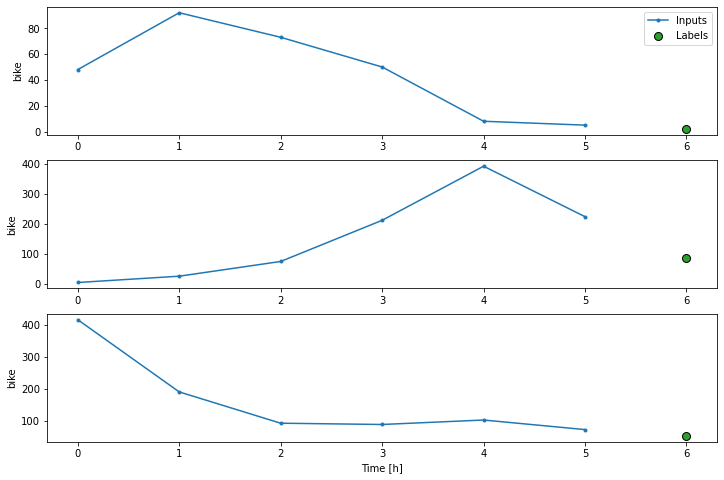

In [58]:
w2.plot()

### Create tf.data.Datasets

In [59]:
# Tutorial uses tf.keras.preprocessing.timeseries_dataset_from_array()
# This function doesn't exist in version 2.1
# Can copy from GitHub and implement directly

In [60]:
# timeseries_dataset_from_array()
# Tensorflow version, from Github, unedited 

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from tensorflow.python.data.ops import dataset_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.util.tf_export import keras_export

def tf_timeseries_dataset_from_array(
        data,
        targets,
        sequence_length,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=128,
        shuffle=False,
        seed=None,
        start_index=None,
        end_index=None):
    """Creates a dataset of sliding windows over a timeseries provided as array.
    This function takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    length of the sequences/windows, spacing between two sequence/windows, etc.,
    to produce batches of timeseries inputs and targets.
    Arguments:
        data: Numpy array or eager tensor
            containing consecutive data points (timesteps).
            Axis 0 is expected to be the time dimension.
        targets: Targets corresponding to timesteps in `data`.
            It should have same length as `data`. `targets[i]` should be the target
            corresponding to the window that starts at index `i`
            (see example 2 below).
            Pass None if you don't have target data (in this case the dataset will
            only yield the input data).
        sequence_length: Length of the output sequences (in number of timesteps).
        sequence_stride: Period between successive output sequences.
            For stride `s`, output samples would
            start at index `data[i]`, `data[i + s]`, `data[i + 2 * s]`, etc.
        sampling_rate: Period between successive individual timesteps
            within sequences. For rate `r`, timesteps
            `data[i], data[i + r], ... data[i + sequence_length]`
            are used for create a sample sequence.
        batch_size: Number of timeseries samples in each batch
            (except maybe the last one).
        shuffle: Whether to shuffle output samples,
            or instead draw them in chronological order.
        seed: Optional int; random seed for shuffling.
        start_index: Optional int; data points earlier (exclusive)
            than `start_index` will not be used
            in the output sequences. This is useful to reserve part of the
            data for test or validation.
        end_index: Optional int; data points later (exclusive) than `end_index`
            will not be used in the output sequences.
            This is useful to reserve part of the data for test or validation.
    Returns:
        A tf.data.Dataset instance. If `targets` was passed, the dataset yields
        tuple `(batch_of_sequences, batch_of_targets)`. If not, the dataset yields
        only `batch_of_sequences`.
    Example 1:
        Consider indices `[0, 1, ... 99]`.
        With `sequence_length=10,    sampling_rate=2, sequence_stride=3`,
        `shuffle=False`, the dataset will yield batches of sequences
        composed of the following indices:
    ```
    First sequence:    [0    2    4    6    8 10 12 14 16 18]
    Second sequence: [3    5    7    9 11 13 15 17 19 21]
    Third sequence:    [6    8 10 12 14 16 18 20 22 24]
    ...
    Last sequence:     [78 80 82 84 86 88 90 92 94 96]
    ```
    In this case the last 3 data points are discarded since no full sequence
    can be generated to include them (the next sequence would have started
    at index 81, and thus its last step would have gone over 99).
    Example 2: temporal regression. Consider an array `data` of scalar
    values, of shape `(steps,)`. To generate a dataset that uses the past 10
    timesteps to predict the next timestep, you would use:
    ```python
    input_data = data[:-10]
    targets = data[10:]
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
            input_data, targets, sequence_length=10)
    for batch in dataset:
        inputs, targets = batch
        assert np.array_equal(inputs[0], data[:10])    # First sequence: steps [0-9]
        assert np.array_equal(targets[0], data[10])    # Corresponding target: step 10
        break
    ```
    """
    # Validate the shape of data and targets
    if targets is not None and len(targets) != len(data):
        raise ValueError('Expected data and targets to have the same number of '
                                         'time steps (axis 0) but got '
                                         'shape(data) = %s; shape(targets) = %s.' %
                                         (data.shape, targets.shape))
    if start_index and (start_index < 0 or start_index >= len(data)):
        raise ValueError('start_index must be higher than 0 and lower than the '
                                         'length of the data. Got: start_index=%s '
                                         'for data of length %s.' % (start_index, len(data)))
    if end_index:
        if start_index and end_index <= start_index:
            raise ValueError('end_index must be higher than start_index. Got: '
                                             'start_index=%s, end_index=%s.' %
                                             (start_index, end_index))
        if end_index >= len(data):
            raise ValueError('end_index must be lower than the length of the data. '
                                             'Got: end_index=%s' % (end_index,))
        if end_index <= 0:
            raise ValueError('end_index must be higher than 0. '
                                             'Got: end_index=%s' % (end_index,))

    # Validate strides
    if sampling_rate <= 0 or sampling_rate >= len(data):
        raise ValueError(
                'sampling_rate must be higher than 0 and lower than '
                'the length of the data. Got: '
                'sampling_rate=%s for data of length %s.' % (sampling_rate, len(data)))
    if sequence_stride <= 0 or sequence_stride >= len(data):
        raise ValueError(
                'sequence_stride must be higher than 0 and lower than '
                'the length of the data. Got: sequence_stride=%s '
                'for data of length %s.' % (sequence_stride, len(data)))

    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(data)

    # Determine the lowest dtype to store start positions (to lower memory usage).
    num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1
    if num_seqs < 2147483647:
        index_dtype = 'int32'
    else:
        index_dtype = 'int64'

    # Generate start positions
    start_positions = np.arange(0, num_seqs, sequence_stride, dtype=index_dtype)
    if shuffle:
        if seed is None:
            seed = np.random.randint(1e6)
        rng = np.random.RandomState(seed)
        rng.shuffle(start_positions)

    sequence_length = math_ops.cast(sequence_length, dtype=index_dtype)
    sampling_rate = math_ops.cast(sampling_rate, dtype=index_dtype)

    positions_ds = dataset_ops.Dataset.from_tensors(start_positions).repeat()

    # For each initial window position, generates indices of the window elements
    indices = dataset_ops.Dataset.zip(
            (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
                    lambda i, positions: math_ops.range(    # pylint: disable=g-long-lambda
                            positions[i],
                            positions[i] + sequence_length * sampling_rate,
                            sampling_rate),
                    num_parallel_calls=dataset_ops.AUTOTUNE)

    dataset = sequences_from_indices(data, indices, start_index, end_index)
    if targets is not None:
        indices = dataset_ops.Dataset.zip(
                (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
                        lambda i, positions: positions[i],
                        num_parallel_calls=dataset_ops.AUTOTUNE)
        target_ds = sequences_from_indices(
                targets, indices, start_index, end_index)
        dataset = dataset_ops.Dataset.zip((dataset, target_ds))
    if shuffle:
        # Shuffle locally at each iteration
        dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
    dataset = dataset.batch(batch_size)
    return dataset


def sequences_from_indices(array, indices_ds, start_index, end_index):
    dataset = dataset_ops.Dataset.from_tensors(array[start_index : end_index])
    dataset = dataset_ops.Dataset.zip((dataset.repeat(), indices_ds)).map(
            lambda steps, inds: array_ops.gather(steps, inds),    # pylint: disable=unnecessary-lambda
            num_parallel_calls=dataset_ops.AUTOTUNE)
    return dataset

In [61]:
def tf_make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf_timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

tf_WindowGenerator.make_dataset = tf_make_dataset

In [62]:
@property
def tf_train(self):
    return self.make_dataset(self.train_df)

@property
def tf_val(self):
    return self.make_dataset(self.val_df)

@property
def tf_test(self):
    return self.make_dataset(self.test_df)

@property
def tf_example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

tf_WindowGenerator.train = tf_train
tf_WindowGenerator.val = tf_val
tf_WindowGenerator.test = tf_test
tf_WindowGenerator.example = tf_example

In [63]:
w2.train.element_spec

(TensorSpec(shape=(None, 6, 14), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [64]:
for example_inputs, example_labels in w2.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 14)
Labels shape (batch, time, features): (32, 1, 1)


# Single Step Models

In [65]:
single_step_window = tf_WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['bike'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['bike']

In [66]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 14)
Labels shape (batch, time, features): (32, 1, 1)


## Baseline

In [67]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [68]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}
column_indices

{'day_sin': 0,
 'day_cos': 1,
 'week_sin': 2,
 'week_cos': 3,
 'year_sin': 4,
 'year_cos': 5,
 'temp': 6,
 'dew': 7,
 'wspd_x': 8,
 'wspd_y': 9,
 'precip': 10,
 'snowdepth': 11,
 'bike': 12,
 'dock': 13}

In [69]:
baseline = Baseline(label_index=column_indices['bike'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

274/274 [==============================] - 1s 3ms/step - loss: 47256.7204 - mean_absolute_error: 141.8066


In [70]:
wide_window = tf_WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['bike'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['bike']

In [71]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 14)
Output shape: (32, 24, 1)


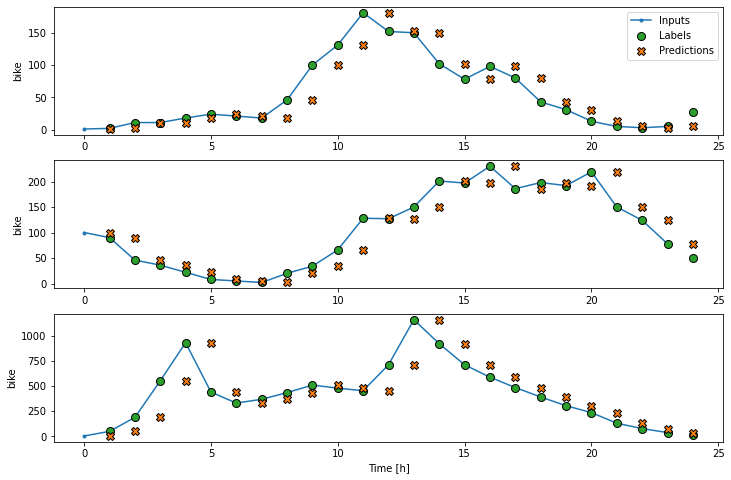

In [72]:
wide_window.plot(baseline)

## Linear

In [73]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [74]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 14)
Output shape: (32, 1, 1)


In [75]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                     patience=patience,
                                     mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                                optimizer=tf.optimizers.Adam(),
                                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                                            validation_data=window.val,
                                            callbacks=[early_stopping])
    return history

In [76]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Train for 1644 steps, validate for 274 steps
Epoch 1/20
1644/1644 [==============================] - 7s 4ms/step - loss: 46918.4038 - mean_absolute_error: 137.0936 - val_loss: 57894.6638 - val_mean_absolute_error: 157.5719
Epoch 2/20
1644/1644 [==============================] - 7s 4ms/step - loss: 40503.3433 - mean_absolute_error: 128.3466 - val_loss: 54269.2553 - val_mean_absolute_error: 151.4830
Epoch 3/20
1644/1644 [==============================] - 6s 4ms/step - loss: 37891.1607 - mean_absolute_error: 122.8914 - val_loss: 50863.9029 - val_mean_absolute_error: 145.1796
Epoch 4/20
1644/1644 [==============================] - 6s 4ms/step - loss: 35445.0902 - mean_absolute_error: 117.5761 - val_loss: 47717.7241 - val_mean_absolute_error: 139.1880
Epoch 5/20
1644/1644 [==============================] - 7s 4ms/step - loss: 33257.8834 - mean_absolute_error: 112.6371 - val_loss: 44908.5276 - val_mean_absolute_error: 133.7416
Epoch 6/20
1644/1644 [==============================] - 7s 4ms/st

In [77]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 14)
Output shape: (32, 24, 1)


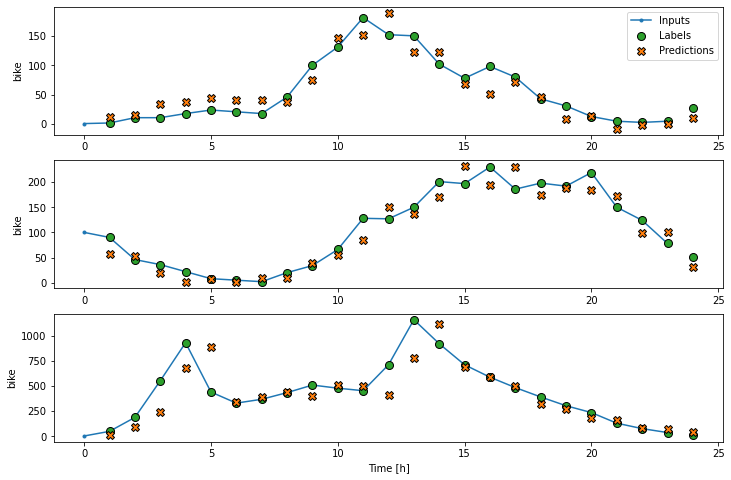

In [78]:
wide_window.plot(linear)

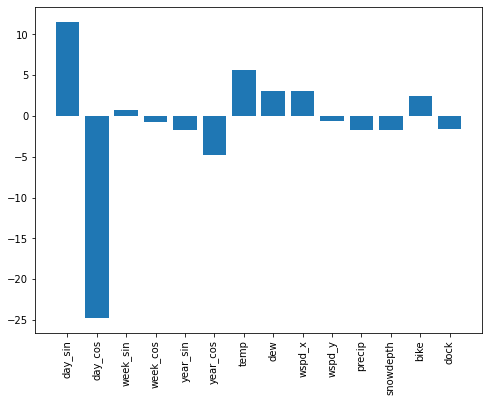

In [79]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [80]:
# Explain weights of Linear Model!

In [81]:
linear.layers[0].kernel[:,0].numpy()

array([ 11.536129  , -24.786968  ,   0.7647696 ,  -0.72344726,
        -1.763278  ,  -4.788236  ,   5.5717354 ,   3.0141919 ,
         3.086337  ,  -0.6704011 ,  -1.7171491 ,  -1.7196068 ,
         2.4453855 ,  -1.5876956 ], dtype=float32)

## Dense

In [82]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Train for 1644 steps, validate for 274 steps
Epoch 1/20
1644/1644 [==============================] - 10s 6ms/step - loss: 21218.4779 - mean_absolute_error: 85.8614 - val_loss: 27034.1233 - val_mean_absolute_error: 98.5386
Epoch 2/20
1644/1644 [==============================] - 9s 6ms/step - loss: 16077.5218 - mean_absolute_error: 75.2622 - val_loss: 22727.4487 - val_mean_absolute_error: 88.8679
Epoch 3/20
1644/1644 [==============================] - 9s 6ms/step - loss: 13872.3426 - mean_absolute_error: 70.2099 - val_loss: 18240.6095 - val_mean_absolute_error: 79.2320
Epoch 4/20
1644/1644 [==============================] - 10s 6ms/step - loss: 11827.8789 - mean_absolute_error: 65.3570 - val_loss: 16522.3652 - val_mean_absolute_error: 73.6547
Epoch 5/20
1644/1644 [==============================] - 9s 5ms/step - loss: 10435.0981 - mean_absolute_error: 61.2787 - val_loss: 19711.3106 - val_mean_absolute_error: 78.8835
Epoch 6/20
1644/1644 [==============================] - 9s 5ms/step - los

## Multi-Step Dense

In [83]:
CONV_WIDTH = 3
conv_window = tf_WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['bike'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['bike']

Text(0.5, 1.0, 'Given 3h as input, predict 1h into the future.')

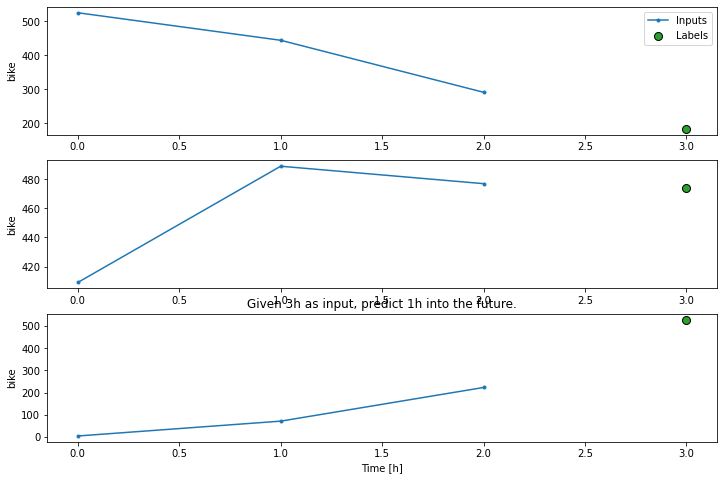

In [84]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

In [85]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [86]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 14)
Output shape: (32, 1, 1)


In [87]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

274/274 [==============================] - 1s 3ms/step - loss: 11655.0533 - mean_absolute_error: 65.9442


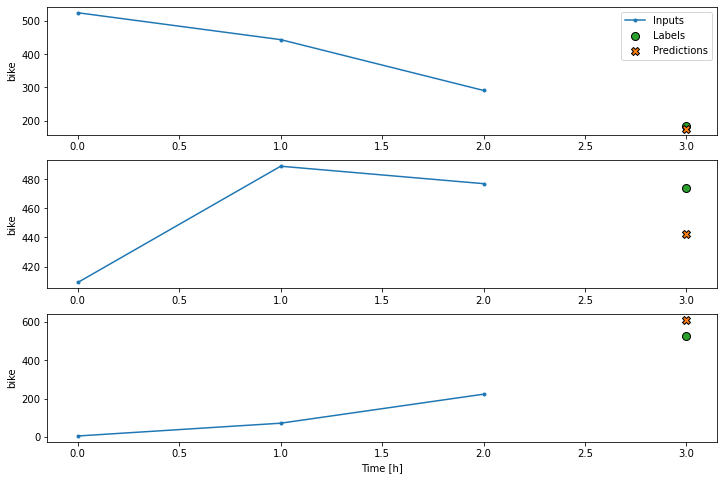

In [88]:
conv_window.plot(multi_step_dense)

Major Disadvantage of dense models: model only runs on input windows of exactly this shape

In [89]:
print('Input shape:', wide_window.example[0].shape)
try:
    print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
    print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 14)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,336], In[1]: [42,32] [Op:MatMul]


## CNN

With a convolutional model, the same model can be applied to a time window of arbitrary size (>= CONV_WIDTH)

In [90]:
conv_model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(filters=32,
                                                     kernel_size=(CONV_WIDTH,),
                                                     activation='relu'),
        tf.keras.layers.Dense(units=32, activation='relu'),
        tf.keras.layers.Dense(units=1),
])

In [91]:
# conv_model.summary()
# ! ValueError: This model has not yet been built

In [92]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 14)
Output shape: (32, 1, 1)


In [93]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 14)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [94]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

274/274 [==============================] - 1s 3ms/step - loss: 7692.5405 - mean_absolute_error: 51.2206


Now we can use this model to generate an array of predictions for windows of arbitary size. (Each output considers the three preceding time steps)

Let's use the wide window. Need to ensure that model output shape matches shape of labels, so extend INPUT_WIDTH by 2:

In [95]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window =  tf_WindowGenerator(
        input_width=INPUT_WIDTH,
        label_width=LABEL_WIDTH,
        shift=1,
        label_columns=['bike'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['bike']

In [96]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 14)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


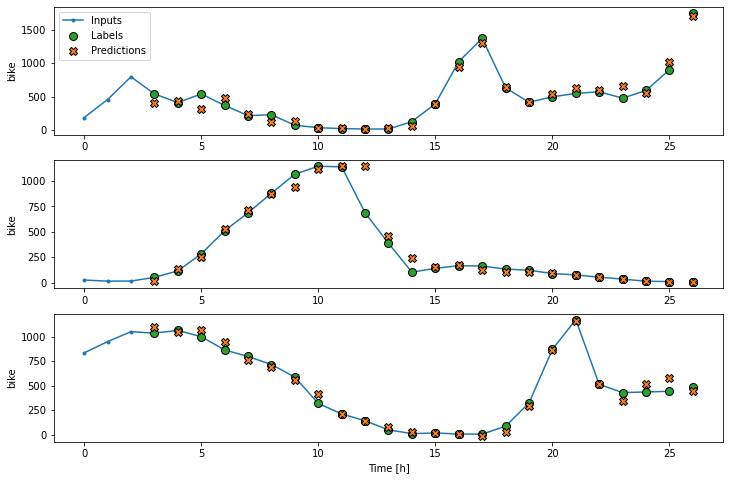

In [97]:
wide_conv_window.plot(conv_model)

## RNN (LSTM)

In [98]:
lstm_model = tf.keras.models.Sequential([
        # Shape [batch, time, features] => [batch, time, lstm_units]
        tf.keras.layers.LSTM(32, return_sequences=True),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(units=1)
])


In [99]:
# return_sequences=True

# Model can train on numerous outputs at a time.
# But this introduces a bias for the earliest samples. 
    # First output cannot see preceding data, so LSTM cell state is not helpful.
        # No better than the sequence-ignorant models from above
    # Later outputs should do better

In [100]:


print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 14)
Output shape: (32, 24, 1)


In [101]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

273/273 [==============================] - 1s 5ms/step - loss: 19215.4690 - mean_absolute_error: 68.7211


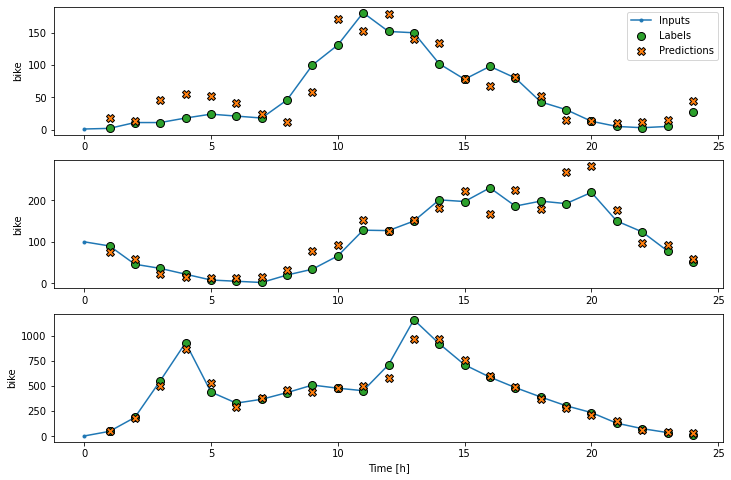

In [102]:
wide_window.plot(lstm_model)

In [103]:
# Plots

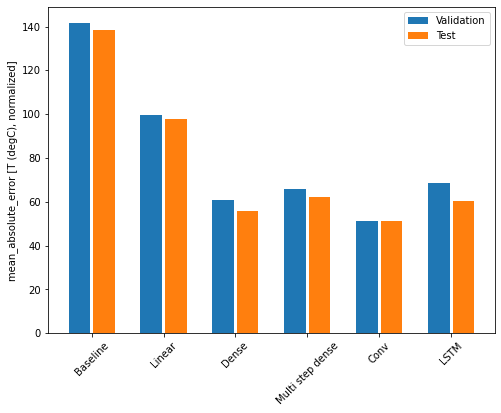

In [104]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
                     rotation=45)
_ = plt.legend()

In [105]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 138.3428
Linear      : 97.8674
Dense       : 55.7309
Multi step dense: 62.3073
Conv        : 51.2080
LSTM        : 60.3630


In [ ]:
assert 3==4

# Current Workspace

## My Rewrite of Data Windowing

In [ ]:
# https://www.tensorflow.org/tutorials/structured_data/time_series
# Walk through windowing section

In [ ]:
# 

In [ ]:
# TSDSFA:

In [ ]:
# my version of TSDSFA
    # 1) includes the bug fix for calculation of num_seqs:
    # 2) select output timestamps with a mask
# &&&& => mods

#@keras_export('keras.preprocessing.timeseries_dataset_from_array', v1=[])
def rek_timeseries_dataset_from_array(
        data,
        targets,
        sequence_length,
        use_accumulation=False,
        cudata=None,
        label_mask=None,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=128,
        shuffle=False,
        seed=None,
        start_index=None,
        end_index=None):
    """Creates a dataset of sliding windows over a timeseries provided as array.

    This function takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    length of the sequences/windows, spacing between two sequence/windows, etc.,
    to produce batches of timeseries inputs and targets.

    Arguments:
        data: Numpy array or eager tensor
            containing consecutive data points (timesteps).
            Axis 0 is expected to be the time dimension.
        targets: Targets corresponding to timesteps in `data`.
            It should have same length as `data`. `targets[i]` should be the target
            corresponding to the window that starts at index `i`
            (see example 2 below).
            Pass None if you don't have target data (in this case the dataset will
            only yield the input data).
        sequence_length: Length of the output sequences (in number of timesteps).
        &&&& use_accumulation: 
        &&&& cudata:
        &&&& label_mask:
        sequence_stride: Period between successive output sequences.
            For stride `s`, output samples would
            start at index `data[i]`, `data[i + s]`, `data[i + 2 * s]`, etc.
        sampling_rate: Period between successive individual timesteps
            within sequences. For rate `r`, timesteps
            `data[i], data[i + r], ... data[i + sequence_length]`
            are used for create a sample sequence.
        batch_size: Number of timeseries samples in each batch
            (except maybe the last one).
        shuffle: Whether to shuffle output samples,
            or instead draw them in chronological order.
        seed: Optional int; random seed for shuffling.
        start_index: Optional int; data points earlier (exclusive)
            than `start_index` will not be used
            in the output sequences. This is useful to reserve part of the
            data for test or validation.
        end_index: Optional int; data points later (exclusive) than `end_index`
            will not be used in the output sequences.
            This is useful to reserve part of the data for test or validation.

    Returns:
        A tf.data.Dataset instance. If `targets` was passed, the dataset yields
        tuple `(batch_of_sequences, batch_of_targets)`. If not, the dataset yields
        only `batch_of_sequences`.

    Example 1:
        Consider indices `[0, 1, ... 99]`.
        With `sequence_length=10,    sampling_rate=2, sequence_stride=3`,
        `shuffle=False`, the dataset will yield batches of sequences
        composed of the following indices:

    ```
    First sequence:    [0    2    4    6    8 10 12 14 16 18]
    Second sequence: [3    5    7    9 11 13 15 17 19 21]
    Third sequence:    [6    8 10 12 14 16 18 20 22 24]
    ...
    Last sequence:     [78 80 82 84 86 88 90 92 94 96]
    ```

    In this case the last 3 data points are discarded since no full sequence
    can be generated to include them (the next sequence would have started
    at index 81, and thus its last step would have gone over 99).

    Example 2: temporal regression. Consider an array `data` of scalar
    values, of shape `(steps,)`. To generate a dataset that uses the past 10
    timesteps to predict the next timestep, you would use:

    ```python
    input_data = data[:-10]
    targets = data[10:]
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
            input_data, targets, sequence_length=10)
    for batch in dataset:
        inputs, targets = batch
        assert np.array_equal(inputs[0], data[:10])    # First sequence: steps [0-9]
        assert np.array_equal(targets[0], data[10])    # Corresponding target: step 10
        break
    ```
    """
    # Validate the shape of data and targets
    if targets is not None and len(targets) != len(data):
        raise ValueError('Expected data and targets to have the same number of '
                                         'time steps (axis 0) but got '
                                         'shape(data) = %s; shape(targets) = %s.' %
                                         (data.shape, targets.shape))
    if start_index and (start_index < 0 or start_index >= len(data)):
        raise ValueError('start_index must be higher than 0 and lower than the '
                                         'length of the data. Got: start_index=%s '
                                         'for data of length %s.' % (start_index, len(data)))
    if end_index:
        if start_index and end_index <= start_index:
            raise ValueError('end_index must be higher than start_index. Got: '
                                             'start_index=%s, end_index=%s.' %
                                             (start_index, end_index))
        if end_index >= len(data):
            raise ValueError('end_index must be lower than the length of the data. '
                                             'Got: end_index=%s' % (end_index,))
        if end_index <= 0:
            raise ValueError('end_index must be higher than 0. '
                                             'Got: end_index=%s' % (end_index,))

    # Validate strides
    if sampling_rate <= 0 or sampling_rate >= len(data):
        raise ValueError(
                'sampling_rate must be higher than 0 and lower than '
                'the length of the data. Got: '
                'sampling_rate=%s for data of length %s.' % (sampling_rate, len(data)))
    if sequence_stride <= 0 or sequence_stride >= len(data):
        raise ValueError(
                'sequence_stride must be higher than 0 and lower than '
                'the length of the data. Got: sequence_stride=%s '
                'for data of length %s.' % (sequence_stride, len(data)))

    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(data)
        
    if (label_mask is not None):
        label_mask = np.ones(len(data)).astype(bool)    
    label_mask[:(self.input_width+self.offset_width)]=False
    # force front edge False, can't use it

    masks_col={'X_input':cols_X_input_window,
               'X_offset':cols_X_offset_window,
               'X_output':cols_X_output_window,
               'y':cols_y,}
    df_col2idx = {cc:j for (j,cc) in enumerate(df.columns)}
    for key in masks_col.keys():
        c_mask=masks_col[key]
        if (c_mask is None):
            masks_col[key]=np.ones(df.shape[1]).astype(bool) # default: use all columns
        if (isinstance(c_mask,str) or isinstance(c_mask,int)):
            c_mask = [c_mask]
        if isinstance(c_mask,list):
            #####cset=np.zeros(df.shape[1]).astype(bool)
            for j in range(len(c_mask)):
                el=c_mask[j]
                assert ((isinstance(el,int) and el in range(df.shape[1]))\
                                            or (el in df_col2idx)), \
                        'bad input , print something here,,,,,,,,,,,,,,'
                if el in df_col2idx:
                    c_mask[j]=df_col2idx[el]
            masks_col[key] = np.isin(np.arange(df.shape[1]),c_mask) # replace sparse list with boolean mask
        print((key,masks_col[key]))
        
        
        
        
        
        
        
        
        
        
        
        

    # Determine the lowest dtype to store start positions (to lower memory usage).
    #num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1   ######## BUG !!!!??
    num_seqs = end_index - start_index - sampling_rate*(sequence_length-1)
    # TF BUG FIXED ^
    
    if num_seqs < 2147483647:
        index_dtype = 'int32'
    else:
        index_dtype = 'int64'

    # Generate start positions
    start_positions = np.arange(0, num_seqs, sequence_stride, dtype=index_dtype)
    if shuffle:
        if seed is None:
            seed = np.random.randint(1e6)
        rng = np.random.RandomState(seed)
        rng.shuffle(start_positions)

    sequence_length = math_ops.cast(sequence_length, dtype=index_dtype)
    sampling_rate = math_ops.cast(sampling_rate, dtype=index_dtype)

    positions_ds = dataset_ops.Dataset.from_tensors(start_positions).repeat()

    # For each initial window position, generates indices of the window elements
    indices = dataset_ops.Dataset.zip(
            (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
                    lambda i, positions: math_ops.range(    # pylint: disable=g-long-lambda
                            positions[i],
                            positions[i] + sequence_length * sampling_rate,
                            sampling_rate),
                    num_parallel_calls=dataset_ops.AUTOTUNE)

    dataset = sequences_from_indices(data, indices, start_index, end_index)
    if targets is not None:
        indices = dataset_ops.Dataset.zip(
                (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
                        lambda i, positions: positions[i],
                        num_parallel_calls=dataset_ops.AUTOTUNE)
        target_ds = sequences_from_indices(
                targets, indices, start_index, end_index)
        dataset = dataset_ops.Dataset.zip((dataset, target_ds))
    if shuffle:
        # Shuffle locally at each iteration
        dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
    dataset = dataset.batch(batch_size)
    return dataset


def sequences_from_indices(array, indices_ds, start_index, end_index):
    dataset = dataset_ops.Dataset.from_tensors(array[start_index : end_index])
    dataset = dataset_ops.Dataset.zip((dataset.repeat(), indices_ds)).map(
            lambda steps, inds: array_ops.gather(steps, inds),    # pylint: disable=unnecessary-lambda
            num_parallel_calls=dataset_ops.AUTOTUNE)
    return dataset

In [ ]:

        """Creates a dataset of sliding windows over a timeseries provided as a DataFrame

        This function takes in a sequence of data-points gathered at
        equal intervals, along with time series parameters such as
        length of the sequences/windows, spacing between two sequence/windows, etc.,
        to produce batches of timeseries inputs and targets.

        Arguments:
            data: Numpy array or eager tensor
                containing consecutive data points (timesteps).
                Axis 0 is expected to be the time dimension.
            targets: Targets corresponding to timesteps in `data`.
                It should have same length as `data`. `targets[i]` should be the target
                corresponding to the window that starts at index `i`
                (see example 2 below).
                Pass None if you don't have target data (in this case the dataset will
                only yield the input data).
            sequence_length: Length of the output sequences (in number of timesteps).
            ### my addition:
            label_mask: b
            ###
            sequence_stride: Period between successive output sequences.
                For stride `s`, output samples would
                start at index `data[i]`, `data[i + s]`, `data[i + 2 * s]`, etc.
            sampling_rate: Period between successive individual timesteps
                within sequences. For rate `r`, timesteps
                `data[i], data[i + r], ... data[i + sequence_length]`
                are used for create a sample sequence.
            batch_size: Number of timeseries samples in each batch
                (except maybe the last one).
            shuffle: Whether to shuffle output samples,
                or instead draw them in chronological order.
            seed: Optional int; random seed for shuffling.
            start_index: Optional int; data points earlier (exclusive)
                than `start_index` will not be used
                in the output sequences. This is useful to reserve part of the
                data for test or validation.
            end_index: Optional int; data points later (exclusive) than `end_index`
                will not be used in the output sequences.
                This is useful to reserve part of the data for test or validation.

        Returns:
            A tf.data.Dataset instance. If `targets` was passed, the dataset yields
            tuple `(batch_of_sequences, batch_of_targets)`. If not, the dataset yields
            only `batch_of_sequences`.

        Example 1:
            Consider indices `[0, 1, ... 99]`.
            With `sequence_length=10,    sampling_rate=2, sequence_stride=3`,
            `shuffle=False`, the dataset will yield batches of sequences
            composed of the following indices:

        ```
        First sequence:    [0    2    4    6    8 10 12 14 16 18]
        Second sequence: [3    5    7    9 11 13 15 17 19 21]
        Third sequence:    [6    8 10 12 14 16 18 20 22 24]
        ...
        Last sequence:     [78 80 82 84 86 88 90 92 94 96]
        ```

        In this case the last 3 data points are discarded since no full sequence
        can be generated to include them (the next sequence would have started
        at index 81, and thus its last step would have gone over 99).

        Example 2: temporal regression. Consider an array `data` of scalar
        values, of shape `(steps,)`. To generate a dataset that uses the past 10
        timesteps to predict the next timestep, you would use:

        ```python
        input_data = data[:-10]
        targets = data[10:]
        dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
                input_data, targets, sequence_length=10)
        for batch in dataset:
            inputs, targets = batch
            assert np.array_equal(inputs[0], data[:10])    # First sequence: steps [0-9]
            assert np.array_equal(targets[0], data[10])    # Corresponding target: step 10
            break
        ```
        """

In [ ]:
class rek_WindowGenerator():
    def __init__(self, input_width, offset_width, output_width, sampling_rate=1):
        # keep it simple: sampling_rate = stride = 1
        self.input_width = input_width
        self.offset_width = offset_width
        self.output_width = output_width
        self.total_window_size = input_width+offset_width+output_width
        
        # change these to lazy compute (slice) ?
        self.input_indices = np.arange(-input_width-offset_width,-offset_width,1)
        self.offset_indices = np.arange(-offset_width,0,1)
        self.output_indices = np.arange(0,output_width,1)
        

    '''
    def make_dataset(self, df, mask_y_timesteps=None,
                        cols_X_input_window=None, 
                        cols_X_offset_window=None, 
                         cols_X_output_window=None,
                         cols_y=None,
                    ):
        data=np.array(df, dtype=np.float32)
        
        
    
    def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds
'''
    
    def make_dataset(self, df, mask_y_timesteps=None,
                        cols_X_input_window=None, 
                        cols_X_offset_window=None, 
                         cols_X_output_window=None,
                         cols_y=None,
                    ):
        """
        Return a TensorFlow Dataset
        """
        # specify cols either as
            # list of names
            # list of indices
            # slice objects on the indices
            # 1-D boolean masks over the column indices
        # regardless, cols will be converted to boolean masks
        if (not(mask_y_timesteps)):
            mask_y_timesteps = np.ones(len(df)).astype(bool) # default: use as many TS as possible
        mask_y_timesteps[:(self.input_width+self.offset_width)]=False # can't use front edge
        
        masks_col={'X_input':cols_X_input_window,
                   'X_offset':cols_X_offset_window,
                   'X_output':cols_X_output_window,
                   'y':cols_y,}
        df_col2idx = {cc:j for (j,cc) in enumerate(df.columns)}
        for key in masks_col.keys():
            c_mask=masks_col[key]
            if (c_mask is None):
                masks_col[key]=np.ones(df.shape[1]).astype(bool) # default: use all columns
            if (isinstance(c_mask,str) or isinstance(c_mask,int)):
                c_mask = [c_mask]
            if isinstance(c_mask,list):
                #####cset=np.zeros(df.shape[1]).astype(bool)
                for j in range(len(c_mask)):
                    el=c_mask[j]
                    assert ((isinstance(el,int) and el in range(df.shape[1]))\
                                                or (el in df_col2idx)), \
                            'bad input , print something here,,,,,,,,,,,,,,'
                    if el in df_col2idx:
                        c_mask[j]=df_col2idx[el]
                masks_col[key] = np.isin(np.arange(df.shape[1]),c_mask) # replace sparse list with boolean mask
            print((key,masks_col[key]))
        
                
        return(4689)
    
    
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Offset indices: {self.offset_indices}',
            f'Output indices: {self.output_indices}'])

In [ ]:
w0 = rek_WindowGenerator(input_width=1,offset_width=5000,output_width=1)
w0

In [ ]:
w0.make_dataset(agg_BD,cols_X_input_window=['dock'],cols_y='bike')

In [ ]:
'''
def make_dataset(self, data, targets=None,
                sequence_length=None,sequence_stride=1,sampling_rate=1,
                batch_size=32,shuffle=False,seed=None):
    data = np.array(data, dtype=np.float32)
    ds = timeseries_dataset_from_array(
        data=data,
        targets=targets,
        sequence_length=self.total_window_size,
        sequence_stride=sequence_stride,
        sampling_rate=sampling_rate,
        shuffle=shuffle,
        batch_size=batch_size,
        seed=seed,
    )

    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset

'''


### Window Generator

In [ ]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                 splits='Q', aggs=True,
                 offsets_vector=None,
               label_columns=None):
        # Store the raw data.
        if (splits=='Q'):
            self.mask_train = train_Q 
            self.mask_val = val_Q
            self.mask_test = test_Q
            if aggs:
                self.df = df_agg_Q
            else:
                self.df = df_full_Q
        else:
            assert(splits=='R')
            self.mask_train = train_R 
            self.mask_val = val_R
            self.mask_test = test_R
            if aggs:
                self.df = df_agg_R
            else:
                self.df = df_full_R

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
            assert all([lc in self.df for lc in label_columns]), 'Cannot find all label_columns'
        self.column_indices = {name: i for i, name in
                               enumerate(self.df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

        
        
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['bike','dock'])
single_step_window

In [ ]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
L=[6,34,6,34,46,34,54,56,56,4,57,54,65,34]
L[slice(-1,0 or None)]

In [ ]:
qwe = slice(3,8)
print(qwe)
print(qwe.indices)
print(qwe.start)
print(qwe.step)
print(qwe.stop)
print(list(np.arange(qwe.start,qwe.stop,qwe.step or 1)))

In [ ]:
w0 = WindowGenerator(input_width=24, label_width=4, shift=12)
w0

In [ ]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, aggs=True,
                     label_columns=['bike'])
w1

In [ ]:
w1a = WindowGenerator(input_width=24, label_width=1, shift=24, aggs=False,
                     label_columns=['B_31258'])
w1a

In [ ]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1, aggs=True,
                     label_columns=['bike'])
w2

### Split Windows:

In [ ]:
def split_window(self, features):
    '''
    from a window object: extract inputs and labels, return them separately
    '''
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
        labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels

WindowGenerator.split_window = split_window

In [ ]:
# Stack three slices, the length of the total window:
idxs_batch = [60000,70000,80000]
example_window = tf.stack([np.array(df_agg_Q[(idx-w2.total_window_size):idx])\
                           for idx in idxs_batch])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

### Plot

In [ ]:
w2.example = example_inputs, example_labels

In [ ]:
def plot(self, model=None, plot_col='bike', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col}')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
              plt.legend()

    plt.xlabel('Time [h]')

WindowGenerator.plot = plot

In [ ]:
w2.plot()

### tf.data.Datasets

In [ ]:
#tf.keras.preprocessing.timeseries_dataset_from_array
# function added after tf 2.1
# can copy the source code here though

# also I found a bug in the existing version in TF: it doesn't use the whole array
# when sampling_rate > 1, it discards training examples near the end of the array for no good reason


In [ ]:
# TF's timeseries_dataset_from_array() is a nice starting point
# but ultimately fails to meet the desired use case

    # 1) len(data) must match len(targets)
        # this plays poorly with the windowing concept
            # cf. 1-D convolution where padding=valid
                # the size should not match!
        # What I want is a function that accepts a time-coord mask
            # returns ds where targets are matched to that mask (e.g. choose the validation set)
    # 2) bug: num_seqs discards legitimate data near edge of ds,  when sampling_rate>1
    # 3) quantities that accumulate
        # one desired dimension of target output: lead_time
            # i.e. let's predict values for multiple lead times simultaneously
        # ideally, we'd pass an array that can be differenced
                    # to obtain the accumulated values over the span of lead_time
            # otherwise required pre-computation of 'targets' would scale with lead_time 
    # 4) I'd like to implement column down-selection
        # separately for:
            # input window
            # offset window
            # output window
        # this can produce multiple differently-shaped submatrices
    # 5) Also want to be able to access more than one array
        # e.g. cumulative vs. raw counts, should pass in separate arrays

In [ ]:
my_scalar=235
my_list1 = [53,46,23]
my_list2 = [[23,64,234,46,23],[35,32,53,24,45],[452,6453,234,46,23]]
my_tuple = (35,2,5)
my_arr1 = np.array([46,123,5,35,4])
my_arr2 = np.array([[3,5,42],[42,3345,23]])
my_ps = pd.Series([46,23,54,23,54,23,34],index=['a','b','c','d','e','f','g'])
my_df = pd.DataFrame()
index_dtype='int32'
print(math_ops.cast(my_scalar, dtype=index_dtype))
print(math_ops.cast(my_list1, dtype=index_dtype))
print(math_ops.cast(my_list2, dtype=index_dtype))
print(math_ops.cast(my_tuple, dtype=index_dtype))
print(math_ops.cast(my_arr1, dtype=index_dtype))
print(math_ops.cast(my_arr2, dtype=index_dtype))

In [ ]:
type(math_ops.cast(my_arr2, dtype=index_dtype))

In [ ]:
# Copied from TF Github
# included the bug fix for calculation of num_seqs:
# &&&& => mods

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from tensorflow.python.data.ops import dataset_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.util.tf_export import keras_export

#@keras_export('keras.preprocessing.timeseries_dataset_from_array', v1=[])
def rek_timeseries_dataset_from_array(
        data,
        targets,
        sequence_length,
        use_accumulation=False,
        cudata=None,
        label_mask=None,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=128,
        shuffle=False,
        seed=None,
        start_index=None,
        end_index=None):
    """Creates a dataset of sliding windows over a timeseries provided as array.

    This function takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    length of the sequences/windows, spacing between two sequence/windows, etc.,
    to produce batches of timeseries inputs and targets.

    Arguments:
        data: Numpy array or eager tensor
            containing consecutive data points (timesteps).
            Axis 0 is expected to be the time dimension.
        targets: Targets corresponding to timesteps in `data`.
            It should have same length as `data`. `targets[i]` should be the target
            corresponding to the window that starts at index `i`
            (see example 2 below).
            Pass None if you don't have target data (in this case the dataset will
            only yield the input data).
        sequence_length: Length of the output sequences (in number of timesteps).
        &&&& use_accumulation: 
        &&&& cudata:
        &&&& label_mask:
        sequence_stride: Period between successive output sequences.
            For stride `s`, output samples would
            start at index `data[i]`, `data[i + s]`, `data[i + 2 * s]`, etc.
        sampling_rate: Period between successive individual timesteps
            within sequences. For rate `r`, timesteps
            `data[i], data[i + r], ... data[i + sequence_length]`
            are used for create a sample sequence.
        batch_size: Number of timeseries samples in each batch
            (except maybe the last one).
        shuffle: Whether to shuffle output samples,
            or instead draw them in chronological order.
        seed: Optional int; random seed for shuffling.
        start_index: Optional int; data points earlier (exclusive)
            than `start_index` will not be used
            in the output sequences. This is useful to reserve part of the
            data for test or validation.
        end_index: Optional int; data points later (exclusive) than `end_index`
            will not be used in the output sequences.
            This is useful to reserve part of the data for test or validation.

    Returns:
        A tf.data.Dataset instance. If `targets` was passed, the dataset yields
        tuple `(batch_of_sequences, batch_of_targets)`. If not, the dataset yields
        only `batch_of_sequences`.

    Example 1:
        Consider indices `[0, 1, ... 99]`.
        With `sequence_length=10,    sampling_rate=2, sequence_stride=3`,
        `shuffle=False`, the dataset will yield batches of sequences
        composed of the following indices:

    ```
    First sequence:    [0    2    4    6    8 10 12 14 16 18]
    Second sequence: [3    5    7    9 11 13 15 17 19 21]
    Third sequence:    [6    8 10 12 14 16 18 20 22 24]
    ...
    Last sequence:     [78 80 82 84 86 88 90 92 94 96]
    ```

    In this case the last 3 data points are discarded since no full sequence
    can be generated to include them (the next sequence would have started
    at index 81, and thus its last step would have gone over 99).

    Example 2: temporal regression. Consider an array `data` of scalar
    values, of shape `(steps,)`. To generate a dataset that uses the past 10
    timesteps to predict the next timestep, you would use:

    ```python
    input_data = data[:-10]
    targets = data[10:]
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
            input_data, targets, sequence_length=10)
    for batch in dataset:
        inputs, targets = batch
        assert np.array_equal(inputs[0], data[:10])    # First sequence: steps [0-9]
        assert np.array_equal(targets[0], data[10])    # Corresponding target: step 10
        break
    ```
    """
    # Validate the shape of data and targets
    if targets is not None and len(targets) != len(data):
        raise ValueError('Expected data and targets to have the same number of '
                                         'time steps (axis 0) but got '
                                         'shape(data) = %s; shape(targets) = %s.' %
                                         (data.shape, targets.shape))
    if start_index and (start_index < 0 or start_index >= len(data)):
        raise ValueError('start_index must be higher than 0 and lower than the '
                                         'length of the data. Got: start_index=%s '
                                         'for data of length %s.' % (start_index, len(data)))
    if end_index:
        if start_index and end_index <= start_index:
            raise ValueError('end_index must be higher than start_index. Got: '
                                             'start_index=%s, end_index=%s.' %
                                             (start_index, end_index))
        if end_index >= len(data):
            raise ValueError('end_index must be lower than the length of the data. '
                                             'Got: end_index=%s' % (end_index,))
        if end_index <= 0:
            raise ValueError('end_index must be higher than 0. '
                                             'Got: end_index=%s' % (end_index,))

    # Validate strides
    if sampling_rate <= 0 or sampling_rate >= len(data):
        raise ValueError(
                'sampling_rate must be higher than 0 and lower than '
                'the length of the data. Got: '
                'sampling_rate=%s for data of length %s.' % (sampling_rate, len(data)))
    if sequence_stride <= 0 or sequence_stride >= len(data):
        raise ValueError(
                'sequence_stride must be higher than 0 and lower than '
                'the length of the data. Got: sequence_stride=%s '
                'for data of length %s.' % (sequence_stride, len(data)))

    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(data)
        
    if (label_mask is not None):
        label_mask = np.ones(len(data)).astype(bool)    
    label_mask[:(self.input_width+self.offset_width)]=False
    # force front edge False, can't use it

    masks_col={'X_input':cols_X_input_window,
               'X_offset':cols_X_offset_window,
               'X_output':cols_X_output_window,
               'y':cols_y,}
    df_col2idx = {cc:j for (j,cc) in enumerate(df.columns)}
    for key in masks_col.keys():
        c_mask=masks_col[key]
        if (c_mask is None):
            masks_col[key]=np.ones(df.shape[1]).astype(bool) # default: use all columns
        if (isinstance(c_mask,str) or isinstance(c_mask,int)):
            c_mask = [c_mask]
        if isinstance(c_mask,list):
            #####cset=np.zeros(df.shape[1]).astype(bool)
            for j in range(len(c_mask)):
                el=c_mask[j]
                assert ((isinstance(el,int) and el in range(df.shape[1]))\
                                            or (el in df_col2idx)), \
                        'bad input , print something here,,,,,,,,,,,,,,'
                if el in df_col2idx:
                    c_mask[j]=df_col2idx[el]
            masks_col[key] = np.isin(np.arange(df.shape[1]),c_mask) # replace sparse list with boolean mask
        print((key,masks_col[key]))
        
        
        
        
        
        
        
        
        
        
        
        

    # Determine the lowest dtype to store start positions (to lower memory usage).
    #num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1   ######## BUG !!!!??
    num_seqs = end_index - start_index - sampling_rate*(sequence_length-1)
    # TF BUG FIXED ^
    
    if num_seqs < 2147483647:
        index_dtype = 'int32'
    else:
        index_dtype = 'int64'

    # Generate start positions
    start_positions = np.arange(0, num_seqs, sequence_stride, dtype=index_dtype)
    if shuffle:
        if seed is None:
            seed = np.random.randint(1e6)
        rng = np.random.RandomState(seed)
        rng.shuffle(start_positions)

    sequence_length = math_ops.cast(sequence_length, dtype=index_dtype)
    sampling_rate = math_ops.cast(sampling_rate, dtype=index_dtype)

    positions_ds = dataset_ops.Dataset.from_tensors(start_positions).repeat()

    # For each initial window position, generates indices of the window elements
    indices = dataset_ops.Dataset.zip(
            (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
                    lambda i, positions: math_ops.range(    # pylint: disable=g-long-lambda
                            positions[i],
                            positions[i] + sequence_length * sampling_rate,
                            sampling_rate),
                    num_parallel_calls=dataset_ops.AUTOTUNE)

    dataset = sequences_from_indices(data, indices, start_index, end_index)
    if targets is not None:
        indices = dataset_ops.Dataset.zip(
                (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
                        lambda i, positions: positions[i],
                        num_parallel_calls=dataset_ops.AUTOTUNE)
        target_ds = sequences_from_indices(
                targets, indices, start_index, end_index)
        dataset = dataset_ops.Dataset.zip((dataset, target_ds))
    if shuffle:
        # Shuffle locally at each iteration
        dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
    dataset = dataset.batch(batch_size)
    return dataset


def sequences_from_indices(array, indices_ds, start_index, end_index):
    dataset = dataset_ops.Dataset.from_tensors(array[start_index : end_index])
    dataset = dataset_ops.Dataset.zip((dataset.repeat(), indices_ds)).map(
            lambda steps, inds: array_ops.gather(steps, inds),    # pylint: disable=unnecessary-lambda
            num_parallel_calls=dataset_ops.AUTOTUNE)
    return dataset

In [ ]:
# Tensorflow version, from Github, unedited (except tabs: 2s->4s)

def tf_timeseries_dataset_from_array(
        data,
        targets,
        sequence_length,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=128,
        shuffle=False,
        seed=None,
        start_index=None,
        end_index=None):
    """Creates a dataset of sliding windows over a timeseries provided as array.
    This function takes in a sequence of data-points gathered at
    equal intervals, along with time series parameters such as
    length of the sequences/windows, spacing between two sequence/windows, etc.,
    to produce batches of timeseries inputs and targets.
    Arguments:
        data: Numpy array or eager tensor
            containing consecutive data points (timesteps).
            Axis 0 is expected to be the time dimension.
        targets: Targets corresponding to timesteps in `data`.
            It should have same length as `data`. `targets[i]` should be the target
            corresponding to the window that starts at index `i`
            (see example 2 below).
            Pass None if you don't have target data (in this case the dataset will
            only yield the input data).
        sequence_length: Length of the output sequences (in number of timesteps).
        sequence_stride: Period between successive output sequences.
            For stride `s`, output samples would
            start at index `data[i]`, `data[i + s]`, `data[i + 2 * s]`, etc.
        sampling_rate: Period between successive individual timesteps
            within sequences. For rate `r`, timesteps
            `data[i], data[i + r], ... data[i + sequence_length]`
            are used for create a sample sequence.
        batch_size: Number of timeseries samples in each batch
            (except maybe the last one).
        shuffle: Whether to shuffle output samples,
            or instead draw them in chronological order.
        seed: Optional int; random seed for shuffling.
        start_index: Optional int; data points earlier (exclusive)
            than `start_index` will not be used
            in the output sequences. This is useful to reserve part of the
            data for test or validation.
        end_index: Optional int; data points later (exclusive) than `end_index`
            will not be used in the output sequences.
            This is useful to reserve part of the data for test or validation.
    Returns:
        A tf.data.Dataset instance. If `targets` was passed, the dataset yields
        tuple `(batch_of_sequences, batch_of_targets)`. If not, the dataset yields
        only `batch_of_sequences`.
    Example 1:
        Consider indices `[0, 1, ... 99]`.
        With `sequence_length=10,    sampling_rate=2, sequence_stride=3`,
        `shuffle=False`, the dataset will yield batches of sequences
        composed of the following indices:
    ```
    First sequence:    [0    2    4    6    8 10 12 14 16 18]
    Second sequence: [3    5    7    9 11 13 15 17 19 21]
    Third sequence:    [6    8 10 12 14 16 18 20 22 24]
    ...
    Last sequence:     [78 80 82 84 86 88 90 92 94 96]
    ```
    In this case the last 3 data points are discarded since no full sequence
    can be generated to include them (the next sequence would have started
    at index 81, and thus its last step would have gone over 99).
    Example 2: temporal regression. Consider an array `data` of scalar
    values, of shape `(steps,)`. To generate a dataset that uses the past 10
    timesteps to predict the next timestep, you would use:
    ```python
    input_data = data[:-10]
    targets = data[10:]
    dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
            input_data, targets, sequence_length=10)
    for batch in dataset:
        inputs, targets = batch
        assert np.array_equal(inputs[0], data[:10])    # First sequence: steps [0-9]
        assert np.array_equal(targets[0], data[10])    # Corresponding target: step 10
        break
    ```
    """
    # Validate the shape of data and targets
    if targets is not None and len(targets) != len(data):
        raise ValueError('Expected data and targets to have the same number of '
                                         'time steps (axis 0) but got '
                                         'shape(data) = %s; shape(targets) = %s.' %
                                         (data.shape, targets.shape))
    if start_index and (start_index < 0 or start_index >= len(data)):
        raise ValueError('start_index must be higher than 0 and lower than the '
                                         'length of the data. Got: start_index=%s '
                                         'for data of length %s.' % (start_index, len(data)))
    if end_index:
        if start_index and end_index <= start_index:
            raise ValueError('end_index must be higher than start_index. Got: '
                                             'start_index=%s, end_index=%s.' %
                                             (start_index, end_index))
        if end_index >= len(data):
            raise ValueError('end_index must be lower than the length of the data. '
                                             'Got: end_index=%s' % (end_index,))
        if end_index <= 0:
            raise ValueError('end_index must be higher than 0. '
                                             'Got: end_index=%s' % (end_index,))

    # Validate strides
    if sampling_rate <= 0 or sampling_rate >= len(data):
        raise ValueError(
                'sampling_rate must be higher than 0 and lower than '
                'the length of the data. Got: '
                'sampling_rate=%s for data of length %s.' % (sampling_rate, len(data)))
    if sequence_stride <= 0 or sequence_stride >= len(data):
        raise ValueError(
                'sequence_stride must be higher than 0 and lower than '
                'the length of the data. Got: sequence_stride=%s '
                'for data of length %s.' % (sequence_stride, len(data)))

    if start_index is None:
        start_index = 0
    if end_index is None:
        end_index = len(data)

    # Determine the lowest dtype to store start positions (to lower memory usage).
    num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1
    if num_seqs < 2147483647:
        index_dtype = 'int32'
    else:
        index_dtype = 'int64'

    # Generate start positions
    start_positions = np.arange(0, num_seqs, sequence_stride, dtype=index_dtype)
    if shuffle:
        if seed is None:
            seed = np.random.randint(1e6)
        rng = np.random.RandomState(seed)
        rng.shuffle(start_positions)

    sequence_length = math_ops.cast(sequence_length, dtype=index_dtype)
    sampling_rate = math_ops.cast(sampling_rate, dtype=index_dtype)

    positions_ds = dataset_ops.Dataset.from_tensors(start_positions).repeat()

    # For each initial window position, generates indices of the window elements
    indices = dataset_ops.Dataset.zip(
            (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
                    lambda i, positions: math_ops.range(    # pylint: disable=g-long-lambda
                            positions[i],
                            positions[i] + sequence_length * sampling_rate,
                            sampling_rate),
                    num_parallel_calls=dataset_ops.AUTOTUNE)

    dataset = sequences_from_indices(data, indices, start_index, end_index)
    if targets is not None:
        indices = dataset_ops.Dataset.zip(
                (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
                        lambda i, positions: positions[i],
                        num_parallel_calls=dataset_ops.AUTOTUNE)
        target_ds = sequences_from_indices(
                targets, indices, start_index, end_index)
        dataset = dataset_ops.Dataset.zip((dataset, target_ds))
    if shuffle:
        # Shuffle locally at each iteration
        dataset = dataset.shuffle(buffer_size=batch_size * 8, seed=seed)
    dataset = dataset.batch(batch_size)
    return dataset

In [ ]:
mydata = np.array([np.arange(x,x+5) for x in range(740000,740200,10)])
print(mydata.shape)
mydata

In [ ]:
# test out TSDFA function:
ds42 = rek_timeseries_dataset_from_array(
        data=mydata[:,:3],
        targets=mydata[:,3:],
        sequence_length=5,
        #use_accumulation=False,
        #cudata=None,
        #label_mask=None,
        sequence_stride=1,
        sampling_rate=2,
        batch_size=8,
        shuffle=False,
        seed=None,
        start_index=None,
        end_index=None)


In [ ]:
for el in ds42:
    print(el)

In [ ]:
sequence_stride=3
start_positions33 = np.arange(0, 25, sequence_stride, dtype='int32')

In [ ]:
positions_ds33 = dataset_ops.Dataset.from_tensors(start_positions33).repeat()

In [ ]:
sequence_length=10
sampling_rate=2


    # For each initial window position, generates indices of the window elements
indices33 = dataset_ops.Dataset.zip(
            (dataset_ops.Dataset.range(len(start_positions33)), positions_ds33)).map(
                    lambda i, positions: (math_ops.range(    # pylint: disable=g-long-lambda
                            positions[i],
                            positions[i] + sequence_length * sampling_rate,
                            sampling_rate),
                                         math_ops.range(    # pylint: disable=g-long-lambda
                            100+positions[i],
                            100+positions[i] + sequence_length * sampling_rate,
                            sampling_rate)),
                    num_parallel_calls=dataset_ops.AUTOTUNE)

In [ ]:
indices33

In [ ]:
for el in positions_ds33:
    print(el)

In [ ]:
interzipper33 = dataset_ops.Dataset.zip(
            (dataset_ops.Dataset.range(len(start_positions33)), positions_ds33))
for el in interzipper33:
    print(el)

In [ ]:
for el in indices33:
    print(el)

In [ ]:
tic=time.time()
qwe = rek_timeseries_dataset_from_array(\
                                 data=df_full_Q.to_numpy(),
                        targets=None,
                        sequence_length=70,
                        #label_mask=None
                        sequence_stride=1,
                        sampling_rate=1,
                        batch_size=128,
                        shuffle=False,
                        seed=None,
                        start_index=None,
                        end_index=None,
                        )
print(time.time()-tic)

In [ ]:
tic=time.time()
j=0
for q in qwe:
    print((j,q.shape))
    j+=1
print(time.time()-tic)

In [ ]:
.to_numpy().shape

In [ ]:
agg_BD.iloc[:,1:].to_numpy()

In [ ]:
# play with TSDFA:
data=[[j]+list(np.random.randint(0,1000,6)) for j in range(100)]
targets=[[[7000+2*j,9000+3*j,6000+5*j],[0,5000+j,5000+2*j]] for j in range(len(data))]
sequence_length=7
label_mask=None
sequence_stride=1
sampling_rate=1
batch_size=4
shuffle=False
seed=None
start_index=None
end_index=None


# 1) VALIDATIONS:
if targets is not None and len(targets) != len(data):
    raise ValueError('Expected data and targets to have the same number of '
                                     'time steps (axis 0) but got '
                                     'shape(data) = %s; shape(targets) = %s.' %
                                     (data.shape, targets.shape))
if start_index and (start_index < 0 or start_index >= len(data)):
    raise ValueError('start_index must be higher than 0 and lower than the '
                                     'length of the data. Got: start_index=%s '
                                     'for data of length %s.' % (start_index, len(data)))
if end_index:
    if start_index and end_index <= start_index:
        raise ValueError('end_index must be higher than start_index. Got: '
                                         'start_index=%s, end_index=%s.' %
                                         (start_index, end_index))
    if end_index >= len(data):
        raise ValueError('end_index must be lower than the length of the data. '
                                         'Got: end_index=%s' % (end_index,))
    if end_index <= 0:
        raise ValueError('end_index must be higher than 0. '
                                         'Got: end_index=%s' % (end_index,))

# Validate strides
if sampling_rate <= 0 or sampling_rate >= len(data):
    raise ValueError(
            'sampling_rate must be higher than 0 and lower than '
            'the length of the data. Got: '
            'sampling_rate=%s for data of length %s.' % (sampling_rate, len(data)))
if sequence_stride <= 0 or sequence_stride >= len(data):
    raise ValueError(
            'sequence_stride must be higher than 0 and lower than '
            'the length of the data. Got: sequence_stride=%s '
            'for data of length %s.' % (sequence_stride, len(data)))

if start_index is None:
    start_index = 0
if end_index is None:
    end_index = len(data)

In [ ]:
# 2) Compute Positions:

# Determine the lowest dtype to store start positions (to lower memory usage).
#num_seqs = end_index - start_index - (sequence_length * sampling_rate) + 1   ######## BUG !!!!??
num_seqs = end_index - start_index - sampling_rate*(sequence_length-1)
# TF BUG FIXED ^

if num_seqs < 2147483647:
    index_dtype = 'int32'
else:
    index_dtype = 'int64'

# Generate start positions
start_positions = np.arange(0, num_seqs, sequence_stride, dtype=index_dtype)
if shuffle:
    if seed is None:
        seed = np.random.randint(1e6)
    rng = np.random.RandomState(seed)
    rng.shuffle(start_positions)

sequence_length = math_ops.cast(sequence_length, dtype=index_dtype)
sampling_rate = math_ops.cast(sampling_rate, dtype=index_dtype)

In [ ]:
positions_ds = dataset_ops.Dataset.from_tensors(start_positions).repeat()
# this is an indefinitely repeating TF DS
    # infinite generator that yields the entire batch every time
    
# presumably the next method can be called to yield the full DS (EagerTensor) each EPOCH

In [ ]:
# For each initial window position, generates indices of the window elements
indices = dataset_ops.Dataset.zip(
        (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
                lambda i, positions: math_ops.range(    # pylint: disable=g-long-lambda
                        positions[i],
                        positions[i] + sequence_length * sampling_rate,
                        sampling_rate),
                num_parallel_calls=dataset_ops.AUTOTUNE)

In [ ]:
dataset_44 = sequences_from_indices(data, indices, start_index, end_index)

In [ ]:
if targets is not None:
    indices = dataset_ops.Dataset.zip(
            (dataset_ops.Dataset.range(len(start_positions)), positions_ds)).map(
                    lambda i, positions: positions[i],
                    num_parallel_calls=dataset_ops.AUTOTUNE)
    target_ds = sequences_from_indices(
            targets, indices, start_index, end_index)
    dataset_44 = dataset_ops.Dataset.zip((dataset_44, target_ds))

In [ ]:
if shuffle:
    # Shuffle locally at each iteration
    dataset_44 = dataset_44.shuffle(buffer_size=batch_size * 8, seed=seed)


In [ ]:
dataset_44 = dataset_44.batch(batch_size)

In [ ]:
g=(q for q in dataset_44)
for el in g:
    print(el)

In [ ]:
def make_dataset(self, data, targets=None,
                sequence_length=None,sequence_stride=1,sampling_rate=1,
                batch_size=32,shuffle=False,seed=None):
    data = np.array(data, dtype=np.float32)
    ds = timeseries_dataset_from_array(
        data=data,
        targets=targets,
        sequence_length=self.total_window_size,
        sequence_stride=sequence_stride,
        sampling_rate=sampling_rate,
        shuffle=shuffle,
        batch_size=batch_size,
        seed=seed,
    )

    ds = ds.map(self.split_window)
    return ds

WindowGenerator.make_dataset = make_dataset

# go back to shuffle=True ?

In [ ]:
w0.split_window()

In [ ]:
# A few more property declarations
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

In [ ]:


WindowGenerator.train = df_agg_Q
WindowGenerator.val = df_agg_Q
WindowGenerator.test = df_agg_Q
WindowGenerator.example = example

# this is borrowed from TF tut nb. Is it useful for my masking approach???

In [ ]:
w2.total_window_size

In [ ]:
bbb = df_bike.to_numpy()

In [ ]:
b000 = bbb[:1000,:100]
b000.shape

In [ ]:
w2.make_dataset

In [ ]:
timeseries_dataset_from_array(
      data=b000,
      targets=None,
      sequence_length=7,#self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

In [ ]:
# Play with my modified timeseries_dataset_from_array

In [ ]:
# Ex1 from https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array

#[0, 1, ... 99]. With sequence_length=10, sampling_rate=2, sequence_stride=3, shuffle=False
   
tdsfa_ex1 = rek_timeseries_dataset_from_array(
        data=list(range(30)),
        label_mask=None,
        targets=None,
        sequence_length=7,
        sequence_stride=1,
        sampling_rate=1,
        batch_size=8,
        start_index=0,
        #end_index=9999999,
        seed=None,
        shuffle=False,)

for batch in tdsfa_ex1:
    inputs = batch
    print(inputs)

In [ ]:
steps_ex2 = 40
seqlen_ex2 = 10
data_ex2 = np.arange(steps_ex2)             #np.array([[j,5*j] for j in range(steps_ex2)])
input_data_ex2 = data_ex2[:-seqlen_ex2]
targets_ex2 = data_ex2[seqlen_ex2:]
dataset = timeseries_dataset_from_array(
                input_data_ex2, targets_ex2, sequence_length=seqlen_ex2)

for batch in dataset:
    inputs, targets = batch
    assert np.array_equal(inputs[0], data_ex2[:10])  # First sequence: steps [0-9]
    assert np.array_equal(targets[0], data_ex2[10])  # Corresponding target: step 10
    break

In [ ]:
targets.shape

In [ ]:
inputs.shape

In [ ]:
np.concatenate([np.array(range(10)),np.array(range(10))],axis=0)

In [ ]:
np.array([[j,5*j] for j in range(20)])

In [ ]:
tdsfa_exb2 = timeseries_dataset_from_array(
      data=b000,
      targets=None,
      sequence_length=7,#self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)
tdsfa_exb2

In [ ]:
# Goal:

# Simplest case:
# shift=1, label_width=1, df_agg_Q val set



In [ ]:
print(np.flatnonzero(val_Q))
print(np.flatnonzero(val_Q)[[0,-1]])